In [39]:
using AstroTime
using CSV
using DataFrames
using LinearAlgebra
using Measurements
using PyCall
using PyPlot
using SiriusB

┌ Info: Precompiling SiriusB [2a15530f-af1a-59c5-8974-53d43438f74d]
└ @ Base loading.jl:1317


In [42]:
orb = pyimport("orbitize")
driver = pyimport("orbitize.driver");

In [2]:
parallax = 376.6801e-3 # arcseconds
pxscale = 0.01; # arcseconds/px

## input data

In [6]:
7.985399074538929 / 2

3.8224731391263167

In [116]:
# guesses from GreeDS outputs of three epochs
pos = [
    119.613 ± 3.8  97.5371 ± 3.8;
    88.4472 ± 3.8  103.814 ± 3.8;
    92.1264 ± 4.1  120.262 ± 4.1;
] # px coordinates

3×2 Matrix{Measurement{Float64}}:
 119.6±3.8   97.5±3.8
  88.4±3.8  103.8±3.8
  92.1±4.1  120.3±4.1

In [117]:
# translate into offset and angle
center = [100.5 100.5]

delta = pos .- center

3×2 Matrix{Measurement{Float64}}:
  19.1±3.8  -3.0±3.8
 -12.1±3.8   3.3±3.8
  -8.4±4.1  19.8±4.1

In [118]:
dist = mapslices(norm, delta, dims=2) .* pxscale .* 1e3

3×1 Matrix{Measurement{Float64}}:
 193.0 ± 38.0
 125.0 ± 38.0
 215.0 ± 41.0

In [119]:
angs = mapslices(v -> atand(reverse(v)...) - 90, delta, dims=2)

3×1 Matrix{Measurement{Float64}}:
 -99.0 ± 11.0
  75.0 ± 17.0
  23.0 ± 11.0

In [120]:
epochs = [
    TTEpoch(2020, 2, 4),
    TTEpoch(2020, 11, 21),
    TTEpoch(2020, 11, 28)
]

3-element Vector{TTEpoch{Float64}}:
 2020-02-04T00:00:00.000 TT
 2020-11-21T00:00:00.000 TT
 2020-11-28T00:00:00.000 TT

In [121]:
epochs_mjd = modified_julian.(epochs) .|> value

3-element Vector{Float64}:
 58883.0
 59174.0
 59181.0

In [122]:
data_in = DataFrame(
    epoch = epochs_mjd,
    object = fill(1, length(epochs)),
    sep = Measurements.value.(dist) |> vec,
    sep_err = Measurements.uncertainty.(dist) |> vec,
    pa = Measurements.value.(angs) |> vec,
    pa_err = Measurements.uncertainty.(angs) |> vec
)

,epoch,object,sep,sep_err,pa,pa_err
,Float64,Int64,Float64,Float64,Float64,Float64
1,58883.0,1,193.413,38.0,-98.8119,11.257
2,59174.0,1,125.001,38.0,74.626,17.4178
3,59181.0,1,214.628,41.0,22.9635,10.9451


In [123]:
data_in |> CSV.write(datadir("sirius-b_astrometry_data.csv"))

"/Users/miles/dev/research/sirius-b/src/../data/sirius-b_astrometry_data.csv"

In [124]:
mydriver = driver.Driver(
    datadir("sirius-b_astrometry_data.csv"),
    "OFTI",
    1, # number of bodies
    3.081, # total system mass M_sun https://iopscience.iop.org/article/10.3847/1538-4357/aa6af8/pdf
    0.3789e3, # parallax in mas https://iopscience.iop.org/article/10.3847/1538-4357/aa6af8/pdf
    mass_err = 0.034,
    plx_err = 0.0014e3
)

PyObject <orbitize.driver.Driver object at 0x15c288d90>

In [144]:
s = mydriver.sampler
orbits = s.run_sampler(Int(1e4));

100192/1000000 orbits found

/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/sampler.py:278: RuntimeWarning: invalid value encountered in remainder
  tau = (self.epochs[min_epoch]/period_new - meananno) % 1
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/kepler.py:82: RuntimeWarning: invalid value encountered in remainder
  manom = (mean_motion*(epochs[:, None] - tau_ref_epoch) - 2*np.pi*tau) % (2.0*np.pi)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/system.py:460: RuntimeWarning: invalid value encountered in remainder
  pa = np.degrees(np.arctan2(ra, dec)) % 360.
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/lnlike.py:51: RuntimeWarning: invalid value encountered in remain

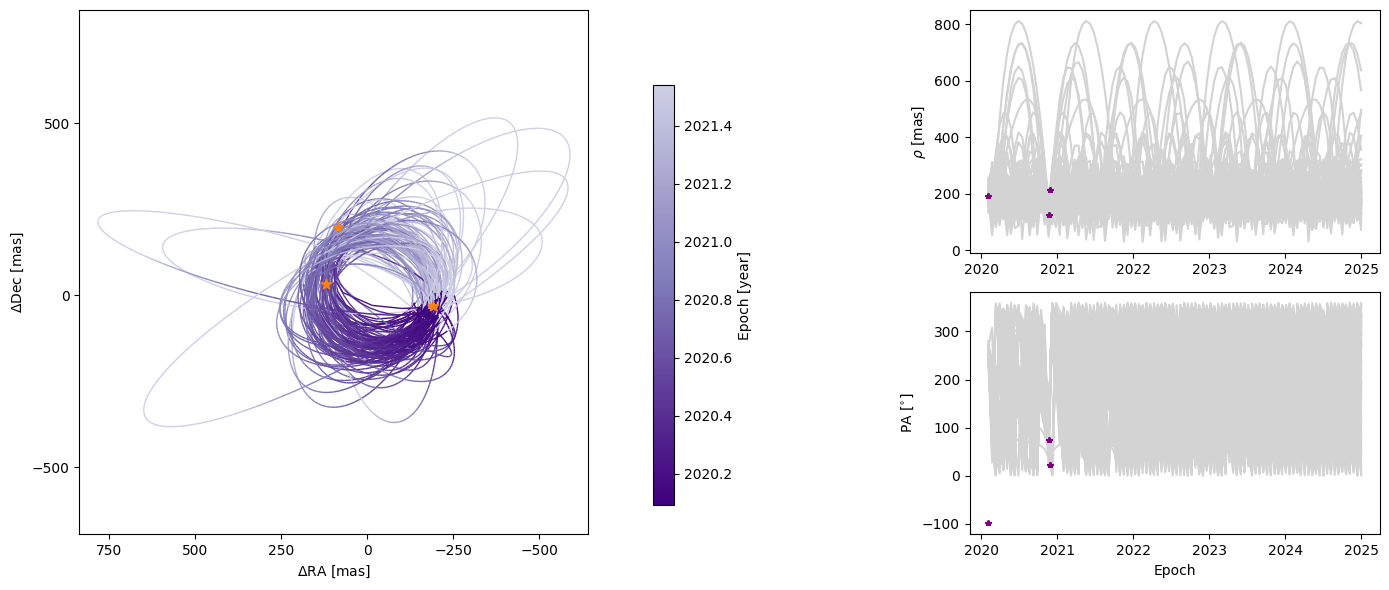

/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/sampler.py:278: RuntimeWarning: invalid value encountered in remainder
  tau = (self.epochs[min_epoch]/period_new - meananno) % 1
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/kepler.py:82: RuntimeWarning: invalid value encountered in remainder
  manom = (mean_motion*(epochs[:, None] - tau_ref_epoch) - 2*np.pi*tau) % (2.0*np.pi)
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/system.py:460: RuntimeWarning: invalid value encountered in remainder
  pa = np.degrees(np.arctan2(ra, dec)) % 360.
/Users/miles/dev/research/sirius-b/.venv/lib/python3.8/site-packages/orbitize/lnlike.py:51: RuntimeWarning: invalid value encountered in remain

In [148]:
s.results.plot_orbits(start_mjd=epochs_mjd[1])
PyPlot.tight_layout()
savefig("/Users/miles/dev/research/sirius-b/paper/figures/orbit.pdf");

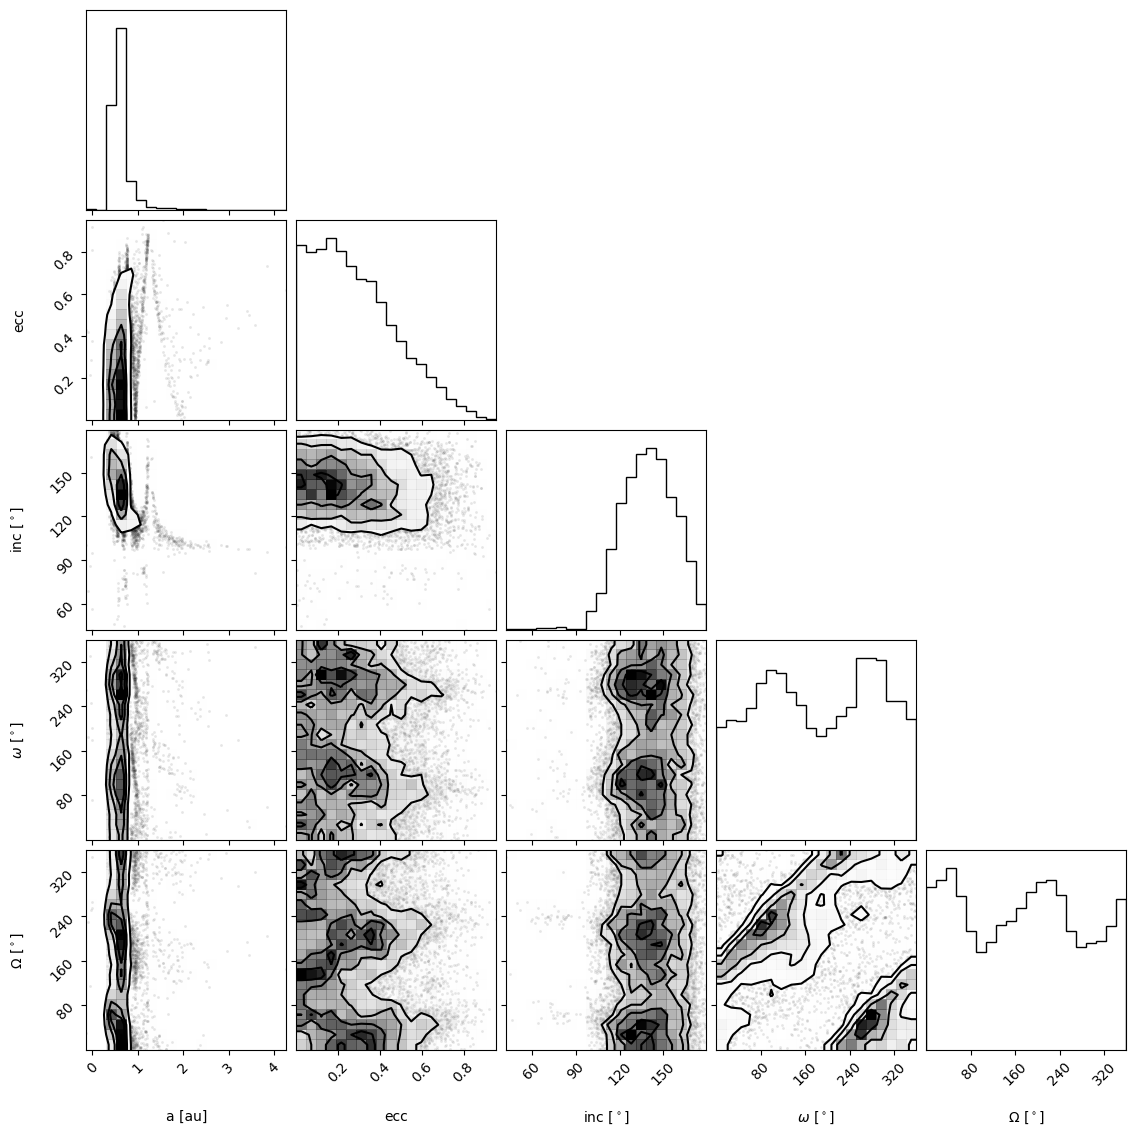

In [146]:
s.results.plot_corner(param_list=["sma1", "ecc1", "inc1", "aop1", "pan1","tau1"]);